In [5]:
import PbPMethods2 as pm2
import GetPbP
from os import getcwd
import pandas as pd
from pylab import *
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit
from statsmodels.regression.linear_model import OLS
from sklearn.decomposition import PCA
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
base = getcwd() + '/'
folder = '/Users/muneebalam/Desktop/Imperial/BA report/'
figfolder = '/Users/muneebalam/Desktop/Imperial/BA report/Figures/'

In [6]:
indivstatsfile = base + 'basic cluster data file.csv'
indivstats = pd.read_csv(indivstatsfile)

Normalize

In [7]:
cols_to_norm = indivstats.columns[1:]
normedcols = []
for col in cols_to_norm:
    normedcols.append('n' + col)
    indivstats[normedcols[-1]] = (indivstats[col] - indivstats[col].mean()) / indivstats[col].std(ddof=0)
indivstats.head()

,Player,RHits/60,RGive/60,RTake/60,G/60,A1/60,A2/60,iG%,iA1%,iA2%,...,niG%,niA1%,niA2%,nPDraw/60,nPTake/60,nFSh%,niSv/60,niM/60,niB/60,nFRbd%
0,nazem kadri,5.959826,1.571976,1.528400,0.605700,0.527017,0.286942,0.280040,0.243661,0.132665,...,0.112609,0.167526,-0.122625,1.767645,0.271826,-0.059030,0.856672,0.907756,1.149340,-0.131670
1,jay rosehill,15.861016,2.725796,0.589977,0.685628,0.000000,0.000000,0.667256,0.000000,0.000000,...,2.408267,-1.326343,-1.149749,5.170809,3.271064,0.600064,-0.562943,-0.112826,-0.126633,-0.129520
2,jujhar khaira,12.482818,0.000000,1.613888,0.000000,0.367100,0.000000,0.000000,0.197440,0.000000,...,-1.547642,-0.115852,-1.149749,-0.612511,1.358156,-0.860141,-0.124476,0.015032,1.431608,-0.129520
3,darroll powe,8.204255,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.149385,-0.918112,-0.860141,-2.444544,4.587190,-1.941578,-0.798238
4,drew miller,7.076461,0.583771,1.113626,0.374268,0.278924,0.163744,0.256342,0.191039,0.112151,...,-0.027888,-0.155097,-0.281450,-0.362371,-0.366717,-0.198769,0.273898,-0.248302,-0.472127,0.185829


Get %s of skills

In [8]:
playerattrfile = folder + 'player strengths_rev.csv'
ps = pd.read_csv(playerattrfile)
ps.drop('Timestamp', axis=1, inplace=True)
ps = ps.transpose()
cols = [x for x in ps.columns]
for i in range(len(cols)):
    cols[i] = 'Response ' + str(cols[i]+1)
ps.columns = cols
skills = ['Passing', 'Shooting', 'Finesse', 'Speed', 'Breakaways', 'Puck Possession',
              'Physical Play', 'Take Aways']
org_n = len(cols)
n_responses = [0 for i in range(len(ps))]
skill_list = {s: [0 for i in range(len(ps))] for s in skills}
for i, row in enumerate(ps.itertuples()):
    data = [x for x in row[1:]]
    for x in data:
        try:
            for s in x.split(','):
                skill_list[s.strip()][i] += 1
            n_responses[i] += 1
        except AttributeError: #math.isnan(x)
            pass
for s in skills:
    ps['Tot '+s.lower()] = skill_list[s]
ps['N_responses'] = n_responses
ps['N_attributes'] = (ps['Tot passing'] + ps['Tot shooting'] + ps['Tot finesse'] 
                      + ps['Tot speed'] + ps['Tot breakaways'] + ps['Tot puck possession']
                      + ps['Tot physical play'] + ps['Tot take aways'])
pctnames = []
for skill in skills:
    pctnames.append(skill + '%')
    ps[pctnames[-1]] = ps['Tot '+skill.lower()] / ps['N_attributes']
ps['Response%'] = ps['N_responses']/org_n
for col in cols:
    ps.drop(col, axis=1, inplace=True)
ps['%sGMean'] = (ps['Passing%'] * ps['Shooting%'] * ps['Finesse%'] 
                      * ps['Speed%'] * ps['Breakaways%'] * ps['Puck Possession%']
                      * ps['Physical Play%'] * ps['Take Aways%'])**(0.125)
ps['Attribute_rate'] = ps['N_attributes'] / ps['N_responses']

mention_rate_names = []
for skill in skills:
    mention_rate_names.append(skill.lower() + '_mention%')
    ps[mention_rate_names[-1]] = ps['Tot ' + skill.lower()]/ps['N_responses']

ps['Player'] = [x.lower() for x in ps.index]
ps.head()

,Tot passing,Tot shooting,Tot finesse,Tot speed,Tot breakaways,Tot puck possession,Tot physical play,Tot take aways,N_responses,N_attributes,...,Attribute_rate,passing_mention%,shooting_mention%,finesse_mention%,speed_mention%,breakaways_mention%,puck possession_mention%,physical play_mention%,take aways_mention%,Player
Patrick Kane,122,120,135,113,99,88,2,39,140,718,...,5.128571,0.871429,0.857143,0.964286,0.807143,0.707143,0.628571,0.014286,0.278571,patrick kane
Thomas Vanek,38,106,57,19,22,6,9,2,122,259,...,2.122951,0.311475,0.868852,0.467213,0.155738,0.180328,0.049180,0.073770,0.016393,thomas vanek
David Krejci,101,31,67,13,6,82,15,44,126,359,...,2.849206,0.801587,0.246032,0.531746,0.103175,0.047619,0.650794,0.119048,0.349206,david krejci
Jarome Iginla,30,119,21,15,12,39,110,21,131,367,...,2.801527,0.229008,0.908397,0.160305,0.114504,0.091603,0.297710,0.839695,0.160305,jarome iginla
Milan Lucic,13,42,2,7,2,47,136,20,136,269,...,1.977941,0.095588,0.308824,0.014706,0.051471,0.014706,0.345588,1.000000,0.147059,milan lucic


Merge

In [9]:
player_strengths_cols = mention_rate_names + ['Player']
indiv_stats_cols = normedcols + ['Player']
df = ps[player_strengths_cols].merge(indivstats[indiv_stats_cols], how='left', on=['Player'])
df.set_index('Player', inplace=True)
df['const'] = 1
df.head()

,passing_mention%,shooting_mention%,finesse_mention%,speed_mention%,breakaways_mention%,puck possession_mention%,physical play_mention%,take aways_mention%,nRHits/60,nRGive/60,...,niA1%,niA2%,nPDraw/60,nPTake/60,nFSh%,niSv/60,niM/60,niB/60,nFRbd%,const
Player,,,,,,,,,,,,,,,,,,,,,
patrick kane,0.871429,0.857143,0.964286,0.807143,0.707143,0.628571,0.014286,0.278571,-1.104972,0.806497,...,0.524171,-0.195830,-0.031607,-0.472224,0.610200,0.777106,0.555513,0.917551,-0.239562,1
thomas vanek,0.311475,0.868852,0.467213,0.155738,0.180328,0.049180,0.073770,0.016393,-0.965903,1.113849,...,0.822729,-0.193683,-0.644256,-0.123786,0.368719,0.307379,0.081460,0.643831,-0.225407,1
david krejci,0.801587,0.246032,0.531746,0.103175,0.047619,0.650794,0.119048,0.349206,-0.792464,0.126764,...,0.520803,0.516658,-0.010712,-0.264310,0.270512,-0.337032,-0.235915,-0.515895,-0.129520,1
jarome iginla,0.229008,0.908397,0.160305,0.114504,0.091603,0.297710,0.839695,0.160305,-0.315549,0.275685,...,0.327507,-0.298869,-0.394500,-0.327451,0.537194,0.107328,-0.011563,0.931155,-0.182145,1
milan lucic,0.095588,0.308824,0.014706,0.051471,0.014706,0.345588,1.000000,0.147059,0.971661,1.154529,...,0.176900,-0.177916,-0.298242,0.126389,0.492974,-0.227558,0.731674,0.459848,-0.165996,1


In [10]:
df.columns

Index(['passing_mention%', 'shooting_mention%', 'finesse_mention%',
       'speed_mention%', 'breakaways_mention%', 'puck possession_mention%',
       'physical play_mention%', 'take aways_mention%', 'nRHits/60',
       'nRGive/60', 'nRTake/60', 'nG/60', 'nA1/60', 'nA2/60', 'niG%', 'niA1%',
       'niA2%', 'nPDraw/60', 'nPTake/60', 'nFSh%', 'niSv/60', 'niM/60',
       'niB/60', 'nFRbd%', 'const'],
      dtype='object')

In [11]:
pca = PCA()
X = indivstats[normedcols].dropna()
pca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [12]:
comp_df = pd.DataFrame(pca.components_)
comp_df.columns = normedcols
comp_df['Component'] = ['Component ' + str(x) for x in comp_df.index]
comp_df.set_index('Component', inplace=True)
comp_df['Explained'] = pca.explained_variance_ratio_
comp_df

,nRHits/60,nRGive/60,nRTake/60,nG/60,nA1/60,nA2/60,niG%,niA1%,niA2%,nPDraw/60,nPTake/60,nFSh%,niSv/60,niM/60,niB/60,nFRbd%,Explained
Component,,,,,,,,,,,,,,,,,
Component 0,0.049590,-0.166821,-0.129714,-0.522942,-0.050372,-0.024032,-0.491892,0.047528,0.057368,-0.061734,-0.026367,-0.359260,-0.333013,-0.278543,-0.326489,-0.011881,0.217433
Component 1,-0.093657,0.168234,0.170860,-0.147281,0.385720,0.158773,-0.264184,0.450829,0.185886,0.010709,-0.094045,-0.359533,0.321385,0.323191,0.290675,-0.001896,0.163964
Component 2,0.021212,0.054633,-0.023097,0.020979,0.329552,-0.447048,0.046097,0.456914,-0.645244,-0.055744,0.113878,0.090900,-0.118349,-0.018346,-0.145317,-0.010078,0.115301
Component 3,-0.664232,0.085234,0.105239,0.080463,0.069187,0.052494,-0.059093,-0.021775,-0.021171,-0.446823,-0.505973,0.167880,-0.138043,-0.124788,-0.059553,-0.002601,0.110728
Component 4,0.125241,0.004913,-0.104507,0.186094,0.370673,0.342454,-0.013062,0.361510,0.416087,0.008621,0.184140,0.425253,-0.296129,-0.195276,-0.194298,0.040946,0.089407
Component 5,-0.104739,0.687126,0.166035,-0.049374,0.021446,-0.015986,0.030802,-0.129801,0.001369,0.304574,0.057548,-0.092849,-0.020300,-0.182449,-0.224031,0.528943,0.056185
Component 6,0.419362,0.002882,-0.301984,0.019490,-0.017039,-0.017849,0.020907,0.028320,0.009619,-0.583538,-0.169796,-0.019550,0.190739,-0.009163,0.067490,0.565564,0.047210
Component 7,-0.305153,0.052073,-0.702471,0.124299,0.102496,0.073497,0.231940,-0.018057,0.047016,0.054976,0.077636,-0.302067,0.160164,0.209061,-0.380644,-0.092044,0.037440
Component 8,0.327086,0.497700,0.148509,-0.022342,0.022112,-0.088629,-0.039666,-0.173865,0.113678,-0.378923,0.010596,0.033304,-0.063518,0.302253,-0.311695,-0.482014,0.033031


In [13]:
print(pca.explained_variance_ratio_)

[ 0.21743265  0.16396426  0.11530108  0.11072799  0.08940706  0.05618505
  0.04720962  0.03743951  0.0330308   0.03140625  0.02590897  0.02177276
  0.01940274  0.01541494  0.00842986  0.00696646]


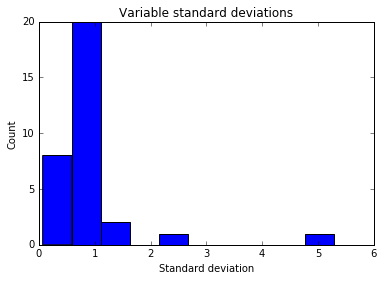

In [14]:
stds = indivstats.describe().transpose()['std']
hist(stds)
xlabel('Standard deviation')
ylabel('Count')
title('Variable standard deviations')

Now run logits

In [15]:
logit_models = {name: None for name in mention_rate_names}
ols_models = {name: None for name in mention_rate_names}
X = df[df.columns[8:]]
X = add_constant(X)
for name in logit_models:
    y = df[name]
    
    log = Logit(y, X)
    logit_models[name] = log.fit()
    
    ols = OLS(y, X)
    ols_models[name] = ols.fit()

Optimization terminated successfully.
         Current function value: 0.389331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.508238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308106
         Iterations 7


In [16]:
i = 0
logit_models[mention_rate_names[i]].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       passing_mention%   No. Observations:                   38
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                           16
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                  0.2373
Time:                        21:48:47   Log-Likelihood:                -20.026
converged:                       True   LL-Null:                       -26.258
                                        LLR p-value:                    0.7115
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
nRHits/60     -0.9089      1.521     -0.598      0.550        -3.889     2.072
nRGive/60     -0.4756      1.270     -0.374      0.708        -2.965     2.014
nRTake/60      0.5594      1.547      0.362      0.718        -2.473     3.592
nG/60         -1.7484      8.761     -0.200      0.842       -18.920    15.423
nA1/60         5.2912     13.133      0.403      0.687       -20.448    31.031
nA2/60        -3.0430     10.394     -0.293      0.770       -23.415    17.328
niG%           1.4273     11.285      0.126      0.899       -20.691    23.545
niA1%         -5.2088     14.275     -0.365      0.715       -33.186    22.769
niA2%          3.7063     10.217      0.363      0.717       -16.318    23.731
nPDraw/60      0.2578      1.368      0.189      0.850        -2.423     2.938
nPTake/60     -0.0507      2.144     -0.024      0.981        -4.253     4.152
nFSh%          2.0079     13.735      0.146      0.884       -24.913    28.929
niSv/60        0.1289      3.947      0.033      0.974        -7.608     7.865
niM/60        -0.0718      1.721     -0.042      0.967        -3.445     3.301
niB/60         0.2139      1.150      0.186      0.852        -2.039     2.467
nFRbd%         0.9434      2.628      0.359      0.720        -4.207     6.094
const         -1.3854      2.231     -0.621      0.535        -5.758     2.988
==============================================================================
"""

In [17]:
print('OLS')
print('i', 'y', 'R2', 'Adj R2')
for i in range(8):
    print(i, mention_rate_names[i], round(ols_models[mention_rate_names[i]].rsquared, 3), 
          round(ols_models[mention_rate_names[i]].rsquared_adj, 3))
print('Logit')
print('i', 'y', 'pseudo R2', 'AIC', 'BIC')
for i in range(8):
    print(i, mention_rate_names[i], round(logit_models[mention_rate_names[i]].prsquared, 3), 
          round(logit_models[mention_rate_names[i]].aic, 3), round(logit_models[mention_rate_names[i]].bic, 3))

OLS
i y R2 Adj R2
0 passing_mention% 0.774 0.602
1 shooting_mention% 0.818 0.679
2 finesse_mention% 0.854 0.744
3 speed_mention% 0.642 0.369
4 breakaways_mention% 0.838 0.714
5 puck possession_mention% 0.705 0.479
6 physical play_mention% 0.865 0.761
7 take aways_mention% 0.652 0.387
Logit
i y pseudo R2 AIC BIC
0 passing_mention% 0.237 74.052 101.891
1 shooting_mention% 0.318 67.12 94.959
2 finesse_mention% 0.295 69.614 97.453
3 speed_mention% 0.251 72.626 100.465
4 breakaways_mention% 0.212 62.376 90.215
5 puck possession_mention% 0.12 78.876 106.715
6 physical play_mention% 0.526 57.416 85.255
7 take aways_mention% 0.061 63.589 91.428


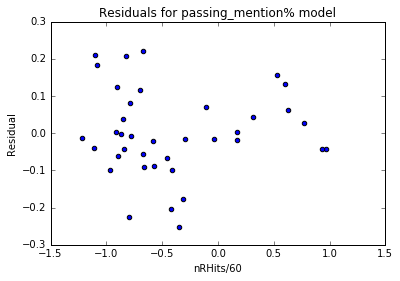

In [18]:
i = 0
j = 8
scatter(df[df.columns[j]], ols_models[mention_rate_names[i]].resid, )
xlabel(df.columns[j])
ylabel('Residual')
title('Residuals for {0:s} model'.format(mention_rate_names[i]))

In [19]:
df.head()

,passing_mention%,shooting_mention%,finesse_mention%,speed_mention%,breakaways_mention%,puck possession_mention%,physical play_mention%,take aways_mention%,nRHits/60,nRGive/60,...,niA1%,niA2%,nPDraw/60,nPTake/60,nFSh%,niSv/60,niM/60,niB/60,nFRbd%,const
Player,,,,,,,,,,,,,,,,,,,,,
patrick kane,0.871429,0.857143,0.964286,0.807143,0.707143,0.628571,0.014286,0.278571,-1.104972,0.806497,...,0.524171,-0.195830,-0.031607,-0.472224,0.610200,0.777106,0.555513,0.917551,-0.239562,1
thomas vanek,0.311475,0.868852,0.467213,0.155738,0.180328,0.049180,0.073770,0.016393,-0.965903,1.113849,...,0.822729,-0.193683,-0.644256,-0.123786,0.368719,0.307379,0.081460,0.643831,-0.225407,1
david krejci,0.801587,0.246032,0.531746,0.103175,0.047619,0.650794,0.119048,0.349206,-0.792464,0.126764,...,0.520803,0.516658,-0.010712,-0.264310,0.270512,-0.337032,-0.235915,-0.515895,-0.129520,1
jarome iginla,0.229008,0.908397,0.160305,0.114504,0.091603,0.297710,0.839695,0.160305,-0.315549,0.275685,...,0.327507,-0.298869,-0.394500,-0.327451,0.537194,0.107328,-0.011563,0.931155,-0.182145,1
milan lucic,0.095588,0.308824,0.014706,0.051471,0.014706,0.345588,1.000000,0.147059,0.971661,1.154529,...,0.176900,-0.177916,-0.298242,0.126389,0.492974,-0.227558,0.731674,0.459848,-0.165996,1


What's next? Figure out how to compare OLS to logit. Do some sort of X-validation. Maybe use bootstrap to deal with small SS. AND WRITE CHEMISTRY CODE!

In [20]:
len(normedcols)

16

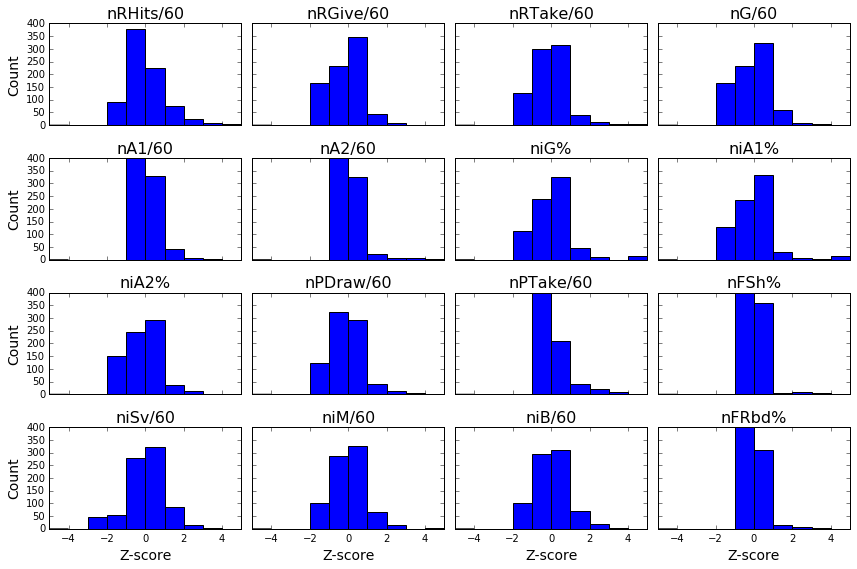

In [21]:
fig, axes = subplots(4, 4, sharex=True, sharey=True, figsize=[12, 8])
for r in range(4):
    for c in range(4):
        try:
            i = 4*r + c
            ax = axes[r, c]
            ax.hist(indivstats[normedcols[i]].dropna(), bins=arange(-5, 20, 1))
            ax.set_title(normedcols[i], fontsize=16)
            ax.set_ylim(top=400)
            ax.set_xlim(-5, 5)
            if r == 3:
                ax.set_xlabel('Z-score', fontsize=14)
            if c == 0:
                ax.set_ylabel('Count', fontsize=14)
        except Exception as e:
            print(i, e, e.args)
fig.tight_layout()
savefig(figfolder + 'normed dist.png')

In [22]:
def get_adjr2(obj):
    return obj.rsquared_adj
def get_aic(obj):
    return obj.aic
def get_bic(obj):
    return obj.bic
def forward_select(X, y, reg_type=OLS, eval_metric=get_adjr2, comparison_metric=max, printresults=True,
                  no_constant=False):
    #add variables from X one-by-one, minimising or maximizing eval_metric.
    if not no_constant:
        X = add_constant(X)
    metrics = None
    models = None
    current_best_vars = set()
    current_best_metric = 0
    while True:
        this_iter_metrics = {}
        this_iter_models = {}
        for var in X.columns:
            if var not in current_best_vars:
                tempset = [x for x in current_best_vars]
                tempset.append(var)
                tempset.sort()
                tempset = tuple(tempset)
                this_iter_metrics[tempset] = 0
                this_iter_models[tempset] = None
        for combo in this_iter_metrics:
            mod = reg_type(y, X[list(combo)])
            modresult = mod.fit()
            this_iter_metrics[combo] = eval_metric(modresult)
            this_iter_models[combo] = modresult
        newmodel = False
        for combo in this_iter_models:
            if len(current_best_vars) == 0 or (comparison_metric(this_iter_metrics[combo], current_best_metric) 
                                               == this_iter_metrics[combo]):
                current_best_vars = set(combo)
                current_best_metric = this_iter_metrics[combo]
                newmodel = True
        if not newmodel:
            mod = reg_type(y, X[list(current_best_vars)])
            return mod.fit()
        if printresults:
            print('Metric = {0:.3f}'.format(current_best_metric), str(current_best_vars))
    if printresults:
        print('Done')
def reverse_select(X, y, reg_type=OLS, eval_metric=get_adjr2, comparison_metric=max, printresults=True,
                  no_constant=False):
    #subtract variables from X one-by-one, minimising or maximizing eval_metric. 
    if not no_constant:
        X = add_constant(X)
    metrics = None
    models = None
    current_best_vars = set([x for x in X.columns])
    mod = reg_type(y, X)
    modresult = mod.fit()
    current_best_metric = eval_metric(modresult)
    while True:
        this_iter_metrics = {}
        this_iter_models = {}
        for var in current_best_vars:
            tempset = [x for x in current_best_vars]
            tempset.remove(var)
            tempset.sort()
            tempset = tuple(tempset)
            this_iter_metrics[tempset] = 0
            this_iter_models[tempset] = None
        for combo in this_iter_metrics:
            mod = reg_type(y, X[list(combo)])
            modresult = mod.fit()
            this_iter_metrics[combo] = eval_metric(modresult)
            this_iter_models[combo] = modresult
        newmodel = False
        for combo in this_iter_models:
            if len(current_best_vars) == 0 or (comparison_metric(this_iter_metrics[combo], current_best_metric) 
                                               == this_iter_metrics[combo]):
                current_best_vars = set(combo)
                current_best_metric = this_iter_metrics[combo]
                newmodel = True
        if not newmodel:
            mod = reg_type(y, X[list(current_best_vars)])
            return mod.fit()
        if printresults:
            print('Metric = {0:.3f}'.format(current_best_metric), str(current_best_vars))
    if printresults:
        print('Done')
def optimize_r2_aic_bic(X, y, no_const_for_aic_bic=True):
    r2mod = forward_select(X, y, OLS, get_adjr2, max, False)
    aicmod = forward_select(X, y, OLS, get_aic, min, False, no_const_for_aic_bic)
    bicmod = forward_select(X, y, OLS, get_bic, min, False, no_const_for_aic_bic)
    print('Item\t\tR2mod\tAICmod\tBICmod')
    print('Params:\t\t{0:d}\t{1:d}\t{2:d}'.format(
            len(r2mod.params), len(aicmod.params), len(bicmod.params)))
    print('Sig at 0.05:\t{0:d}\t{1:d}\t{2:d}'.format(
            len([x for x in r2mod.pvalues if x <= 0.05]), 
            len([x for x in aicmod.pvalues if x <= 0.05]), 
            len([x for x in bicmod.pvalues if x <= 0.05])))
    print('Sig at 0.1:\t{0:d}\t{1:d}\t{2:d}'.format(
            len([x for x in r2mod.pvalues if x <= 0.1]), 
            len([x for x in aicmod.pvalues if x <= 0.1]), 
            len([x for x in bicmod.pvalues if x <= 0.1])))
    print('Adj R2:\t\t{0:.3f}\t{1:.3f}\t{2:.3f}'.format(
            r2mod.rsquared_adj, aicmod.rsquared_adj, bicmod.rsquared_adj))
    print('AIC:\t\t{0:.1f}\t{1:.1f}\t{2:.1f}'.format(
            r2mod.aic, aicmod.aic, bicmod.aic))
    print('BIC\t\t{0:.1f}\t{1:.1f}\t{2:.1f}'.format(
            r2mod.bic, aicmod.bic, bicmod.bic))
    return (r2mod, aicmod, bicmod)    

In [23]:
best_mods = {name: None for name in mention_rate_names}
coeffs = {name: None for name in mention_rate_names}

dep = 'passing_mention%'
indep = ['nRHits/60', 'nA1/60', 'niA1%', 'nFRbd%']
ols = OLS(df[dep], add_constant(df[indep]))
best_mods[dep] = ols.fit() 
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

dep = 'shooting_mention%'
indep = ['niSv/60', 'niA1%', 'nFSh%']
ols = OLS(df[dep], add_constant(df[indep]))
best_mods[dep] = ols.fit()
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

dep = 'finesse_mention%'
indep = ['nPDraw/60', 'nRHits/60', 'nG/60']
ols = OLS(df[dep], add_constant(df[indep]))
best_mods[dep] = ols.fit()
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

dep = 'speed_mention%'
indep = ['niSv/60', 'nPDraw/60', 'nG/60', 'nFSh%']
ols = OLS(df[dep], add_constant(df[indep]))
best_mods[dep] = ols.fit()
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

dep = 'breakaways_mention%'
indep = ['nPDraw/60', 'nG/60', 'nRHits/60']
remove = ['jamie benn']
ols = OLS(df[~(df.index == 'jamie benn')][dep], add_constant(df[~(df.index == 'jamie benn')][indep]))
best_mods[dep] = ols.fit()
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

dep = 'puck possession_mention%'
indep = ['nG/60', 'nA2/60']
ols = OLS(df[~((df.index == 'jamie benn') & (df.index == 'alex ovechkin'))][dep], 
          add_constant(df[~((df.index == 'jamie benn') & (df.index == 'alex ovechkin'))][indep]))
best_mods[dep] = ols.fit()
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

dep = 'physical play_mention%'
indep = ['nRHits/60']
ols = OLS(df[dep], add_constant(df[indep]))
best_mods[dep] = ols.fit()
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

dep = 'take aways_mention%'
indep = ['nFRbd%', 'niM/60', 'nA1/60']
ols = OLS(df[dep], add_constant(df[indep]))
best_mods[dep] = ols.fit()
coeffs[dep] = {param: coeff for param, coeff in zip(best_mods[dep].params.index, best_mods[dep].params.values)}

In [31]:
dep = mention_rate_names[7]
print(best_mods[dep].summary())

                             OLS Regression Results                            
Dep. Variable:     take aways_mention%   R-squared:                       0.374
Model:                             OLS   Adj. R-squared:                  0.319
Method:                  Least Squares   F-statistic:                     6.783
Date:                 Wed, 31 Aug 2016   Prob (F-statistic):            0.00105
Time:                         21:56:11   Log-Likelihood:                 35.300
No. Observations:                   38   AIC:                            -62.60
Df Residuals:                       34   BIC:                            -56.05
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1891      0.040      4.75

In [21]:
indivstats['const'] = 1
for name in mention_rate_names:
    name2 = 'pred_' + name
    indivstats[name2] = 0
    for param, coeff in coeffs[name].items():
        indivstats[name2] = indivstats[name2] + coeff * indivstats[param]
indivstats.head()
indivstats.to_csv(folder + 'skill pred.csv')

In [676]:
indivstats.Player[indivstats.isnull().any(1)]

3              darroll powe
19         pascal pelletier
28             bud holloway
45             keith aucoin
67             bobby robins
84            david steckel
96            brandon tanev
108         michael keranen
154       henrik samuelsson
169      markus hannikainen
176            justin shugg
192            brett bulmer
244             bill arnold
251     chandler stephenson
252         brandon defazio
262             arron asham
268           benn ferriero
272             jim o'brien
273        alexandre bolduc
308           brendan woods
330           stefan noesen
343              david wolf
354             dana tyrell
366            brody sutter
368           gilbert brule
375          aaron palushaj
382         patrick holland
391          cole schneider
398    pierre-cedric labrie
427            dominik uher
444      christoph bertschy
467            eric selleck
496       nicolas deschamps
504         joonas nattinen
515           brett gallant
524             phil

In [645]:
i = 5
print('y = ', mention_rate_names[i])
df2 = df[~((df.index == 'jamie benn') & (df.index == 'alex ovechkin'))]
mods = optimize_r2_aic_bic(df2[normedcols], df2[mention_rate_names[i]])

y =  puck possession_mention%
Item		R2mod	AICmod	BICmod
Params:		14	7	6
Sig at 0.05:	3	5	5
Sig at 0.1:	7	6	6
Adj R2:		0.926	0.905	0.900
AIC:		-39.7	-34.5	-33.5
BIC		-16.8	-23.0	-23.7


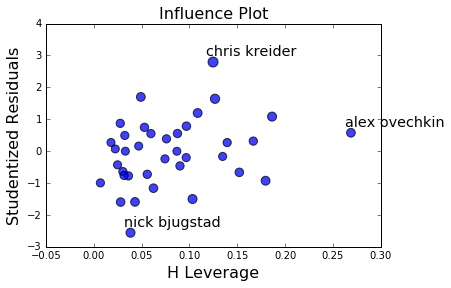

In [650]:
fig = sm.graphics.influence_plot(best_mods['breakaways_mention%'], size=10)

In [646]:
print(mods[0].summary())

                               OLS Regression Results                               
Dep. Variable:     puck possession_mention%   R-squared:                       0.953
Model:                                  OLS   Adj. R-squared:                  0.926
Method:                       Least Squares   F-statistic:                     34.90
Date:                      Tue, 30 Aug 2016   Prob (F-statistic):           1.58e-12
Time:                              18:45:36   Log-Likelihood:                 33.842
No. Observations:                        38   AIC:                            -39.68
Df Residuals:                            24   BIC:                            -16.76
Df Model:                                14                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

In [647]:
print(mods[1].summary())

                               OLS Regression Results                               
Dep. Variable:     puck possession_mention%   R-squared:                       0.922
Model:                                  OLS   Adj. R-squared:                  0.905
Method:                       Least Squares   F-statistic:                     52.66
Date:                      Tue, 30 Aug 2016   Prob (F-statistic):           1.90e-15
Time:                              18:45:36   Log-Likelihood:                 24.245
No. Observations:                        38   AIC:                            -34.49
Df Residuals:                            31   BIC:                            -23.03
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

In [648]:
print(mods[2].summary())

                               OLS Regression Results                               
Dep. Variable:     puck possession_mention%   R-squared:                       0.916
Model:                                  OLS   Adj. R-squared:                  0.900
Method:                       Least Squares   F-statistic:                     58.25
Date:                      Tue, 30 Aug 2016   Prob (F-statistic):           7.79e-16
Time:                              18:45:36   Log-Likelihood:                 22.762
No. Observations:                        38   AIC:                            -33.52
Df Residuals:                            32   BIC:                            -23.70
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

In [656]:
params = [x for x in mods[2].params.index]
to_remove = ['nRGive/60', 'niB/60', 'nA1/60', 'nFRbd%']
to_del = {'jamie benn', 'alex ovechkin'}
def index_to_remove(obj):
    if obj in to_del:
        return False
    return True
for var in to_remove:
    params.remove(var)
ols = OLS(df[~(df.index == 'jamie benn')][mention_rate_names[i]], df[~(df.index == 'jamie benn')][params])
mod = ols.fit()
print(mod.summary())

                               OLS Regression Results                               
Dep. Variable:     puck possession_mention%   R-squared:                       0.871
Model:                                  OLS   Adj. R-squared:                  0.864
Method:                       Least Squares   F-statistic:                     118.2
Date:                      Tue, 30 Aug 2016   Prob (F-statistic):           2.71e-16
Time:                              18:56:59   Log-Likelihood:                 15.045
No. Observations:                        37   AIC:                            -26.09
Df Residuals:                            35   BIC:                            -22.87
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

In [618]:
df[~(df.index == 'jamie benn')]

37

In [633]:
mods[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     breakaways_mention%   R-squared:                       0.903
Model:                             OLS   Adj. R-squared:                  0.895
Method:                  Least Squares   F-statistic:                     105.7
Date:                 Tue, 30 Aug 2016   Prob (F-statistic):           2.63e-17
Time:                         17:12:28   Log-Likelihood:                 33.278
No. Observations:                   37   AIC:                            -60.56
Df Residuals:                       34   BIC:                            -55.72
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
nPDraw/60      0.2504      0.053      4.759      0.000         0.143     0.357
nRHits/60     -0.0871      0.027     -3.185      0.003        -0.143    -0.032
nG/60          0.3007      0.023     12.912      0.000         0.253     0.348
==============================================================================
Omnibus:                        0.406   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.034
Skew:                           0.053   Prob(JB):                        0.983
Kurtosis:                       3.102   Cond. No.                         3.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [635]:
mods[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     breakaways_mention%   R-squared:                       0.879
Model:                             OLS   Adj. R-squared:                  0.868
Method:                  Least Squares   F-statistic:                     84.45
Date:                 Tue, 30 Aug 2016   Prob (F-statistic):           4.25e-16
Time:                         17:12:38   Log-Likelihood:                 29.942
No. Observations:                   38   AIC:                            -53.88
Df Residuals:                       35   BIC:                            -48.97
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
nPDraw/60      0.1998      0.056      3.577      0.001         0.086     0.313
nRHits/60     -0.0955      0.030     -3.141      0.003        -0.157    -0.034
nG/60          0.2776      0.025     11.265      0.000         0.228     0.328
==============================================================================
Omnibus:                        1.150   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                0.406
Skew:                          -0.181   Prob(JB):                        0.816
Kurtosis:                       3.355   Cond. No.                         3.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
df.columns

Index(['passing_mention%', 'shooting_mention%', 'finesse_mention%',
       'speed_mention%', 'breakaways_mention%', 'puck possession_mention%',
       'physical play_mention%', 'take aways_mention%', 'nRHits/60',
       'nRGive/60', 'nRTake/60', 'nG/60', 'nA1/60', 'nA2/60', 'niG%', 'niA1%',
       'niA2%', 'nPDraw/60', 'nPTake/60', 'nFSh%', 'niSv/60', 'niM/60',
       'niB/60', 'nFRbd%', 'const'],
      dtype='object')

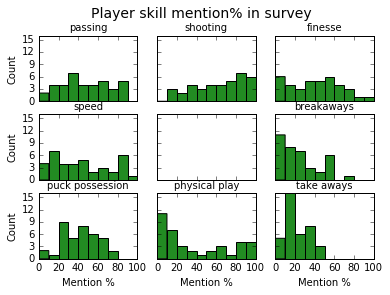

In [28]:
fig, axes = subplots(3, 3, sharex=True, sharey=True)
i = 0
for r in range(3):
    for c in range(3):
        if not (r == 1 and c == 1):
            ax = axes[r, c]
            ax.hist(df[mention_rate_names[i]], color='forestgreen', bins=arange(0, 1.01, 0.1))
            ax.set_title(mention_rate_names[i][:mention_rate_names[i].index('_')], fontsize=10)
            ax.set_xlim(0, 1)
            i += 1
        if r == 2:
            ax.set_xlabel('Mention %')
            ax.set_xticks(arange(0, 1.01, 0.2))
            ax.set_xticklabels(arange(0, 101, 20))
        if c == 0:
            ax.set_ylabel('Count')
            ax.set_yticks(arange(0, 16, 3))
            ax.set_yticklabels(arange(0, 16, 3))
fig.suptitle('Player skill mention% in survey', fontsize=14, va='top', y=1.0)
#fig.tight_layout()
savefig(figfolder + 'skill% dist survey.png')